In [4]:
import numpy as np
# generate SEM
import sys
sys.path.append("..")
import scipy.stats as scistats
from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m
from timeit import default_timer as timer
from importlib import reload  # Python 3.4+
reload(linear)
import matplotlib.pyplot as plt

In [46]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [6]:
utils.set_random_seed(1)

n, d, s0, graph_type, sem_type = 50, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {d} nodes and {s0} edges, {n} samples.")

B_true = utils.simulate_dag(d, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, n, sem_type)

W_est, h_val = linear.notears_linear(X, lambda1=0.1, loss_type='l2-var', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 50 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 2.3  0.  -0.4  0.   0.4]
 [-0.6  0.   0.   0.   0. ]
 [-1.1  0.   0.   0.   0. ]
 [ 0.3  0.   0.   0.   0. ]].

{'fdr': 0.6666666666666666, 'tpr': 0.4, 'fpr': 0.8, 'shd': 7, 'nnz': 6}


In [82]:
Ps = range(32, 72, 2)
print(list(Ps))
T = 1000

r_NT = [[[] for _ in range(6)] for _ in range(len(Ps))]
r_OMP = [[[] for _ in range(6)] for _ in range(len(Ps))]

[32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70]


In [84]:
# numer of iterations
iters = 10

# number of different node sizes to try
for i, p in enumerate(Ps):
    
    print(f"{p}:", end = "\t")
    
    graph_type, sem_type = 'ER', 'gauss'
    s0 = int(min(2 * p, p * (p - 1) / 2))
    
    # number of iterations, more accurate results
    for j in range(iters):
        print(j, end = "\t")
    
        B_true = utils.simulate_dag(p, s0, graph_type)
        W_true = utils.simulate_parameter(B_true)
        X = utils.simulate_linear_sem(W_true, T, sem_type)
        
        ## NOTEARS
        notears_timer = timer()
        W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False, w_threshold = 0.30)
        r_NT[i][0].append(timer() - notears_timer)
        
        # get accuracy
        acc = utils.count_accuracy(B_true, W_est != 0)
        
        # append results
        r_NT[i][1].append(acc['tpr'])
        r_NT[i][2].append(acc['fdr'])
        r_NT[i][3].append(acc['shd'])
        r_NT[i][4].append(h.MSE(W_est, X, is_sem = True))
        r_NT[i][5].append(acc['fpr'])

        print(r_NT[i])

        ## OMP
#         omp_timer = timer()
#         W, r = m._K_OMP(X, X, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 0.1)
#         W[np.abs(W) <= 0.3] = 0
#         r_OMP[i][0].append(timer() - omp_timer)

#         acc = utils.count_accuracy(B_true, W != 0)

#         r_OMP[i][1].append(acc['tpr'])
#         r_OMP[i][2].append(acc['fdr'])
#         r_OMP[i][3].append(acc['shd'])
#         r_OMP[i][4].append(h.MSE(W, X, is_sem = True))
#         r_OMP[i][5].append(acc['fpr'])
        
#         print(r_OMP[i])

    # np.savetxt(f"r_OMP_{p}.txt", r_OMP[i])
    np.savetxt(f"r_NT_{p}.txt", r_NT[i])
    
    print()

32:	0	[[140.54597719999947], [1.0], [0.0], [0], [34.02741942915394], [0.0]]
1	[[140.54597719999947, 90.33760510000138], [1.0, 0.9375], [0.0, 0.16666666666666666], [0, 14], [34.02741942915394, 34.57362467638496], [0.0, 0.027777777777777776]]
2	[[140.54597719999947, 90.33760510000138, 229.6892248999975], [1.0, 0.9375, 0.953125], [0.0, 0.16666666666666666, 0.19736842105263158], [0, 14, 15], [34.02741942915394, 34.57362467638496, 39.66280059400095], [0.0, 0.027777777777777776, 0.034722222222222224]]
3	[[140.54597719999947, 90.33760510000138, 229.6892248999975, 235.63148079999883], [1.0, 0.9375, 0.953125, 1.0], [0.0, 0.16666666666666666, 0.19736842105263158, 0.0], [0, 14, 15, 0], [34.02741942915394, 34.57362467638496, 39.66280059400095, 33.07730920245494], [0.0, 0.027777777777777776, 0.034722222222222224, 0.0]]
4	[[140.54597719999947, 90.33760510000138, 229.6892248999975, 235.63148079999883, 490.31242459999703], [1.0, 0.9375, 0.953125, 1.0, 0.859375], [0.0, 0.16666666666666666, 0.1973684210

8	[[170.4041722000038, 427.36566219999804, 122.84125679999852, 121.56105870000465, 243.47065629999997, 287.34500009999465, 355.78536209999584, 324.60848650000116, 453.91063369999756], [0.9411764705882353, 0.9411764705882353, 0.9852941176470589, 0.9852941176470589, 0.9411764705882353, 0.9411764705882353, 0.9558823529411765, 0.8970588235294118, 0.9117647058823529], [0.09859154929577464, 0.08571428571428572, 0.014705882352941176, 0.028985507246376812, 0.14666666666666667, 0.09859154929577464, 0.17721518987341772, 0.1643835616438356, 0.1388888888888889], [10, 8, 1, 2, 13, 10, 14, 18, 14], [37.098456176203804, 40.39732141475306, 35.17703229937858, 34.84065727055026, 48.60513739683655, 82.11281408733203, 175.19095990629512, 42.897262480279224, 193.94514534205237], [0.014198782961460446, 0.012170385395537525, 0.002028397565922921, 0.004056795131845842, 0.02231237322515213, 0.014198782961460446, 0.028397565922920892, 0.02434077079107505, 0.02028397565922921]]
9	[[170.4041722000038, 427.3656621

5	[[135.28256339999643, 136.14528789999895, 222.6878571999987, 202.26820379999845, 269.36965279999276, 295.1931817999939], [1.0, 1.0, 0.9210526315789473, 0.9078947368421053, 0.9078947368421053, 0.9342105263157895], [0.0, 0.0, 0.2222222222222222, 0.11538461538461539, 0.25, 0.1744186046511628], [0, 0, 23, 12, 28, 19], [38.52446119483589, 40.94051310924618, 44.377480243343975, 47.578308157507266, 43.17425580688514, 106.37219686564092], [0.0, 0.0, 0.03189792663476874, 0.014354066985645933, 0.03668261562998405, 0.023923444976076555]]
6	[[135.28256339999643, 136.14528789999895, 222.6878571999987, 202.26820379999845, 269.36965279999276, 295.1931817999939, 239.88451730000088], [1.0, 1.0, 0.9210526315789473, 0.9078947368421053, 0.9078947368421053, 0.9342105263157895, 0.9605263157894737], [0.0, 0.0, 0.2222222222222222, 0.11538461538461539, 0.25, 0.1744186046511628, 0.09876543209876543], [0, 0, 23, 12, 28, 19, 10], [38.52446119483589, 40.94051310924618, 44.377480243343975, 47.578308157507266, 43.

42:	0	[[689.6946701999987], [0.9761904761904762], [0.06818181818181818], [7], [61.216119791800494], [0.007722007722007722]]
1	[[689.6946701999987, 1053.336152099997], [0.9761904761904762, 0.9523809523809523], [0.06818181818181818, 0.058823529411764705], [7, 9], [61.216119791800494, 57.832446706767094], [0.007722007722007722, 0.006435006435006435]]
2	[[689.6946701999987, 1053.336152099997, 565.7682954000047], [0.9761904761904762, 0.9523809523809523, 0.9880952380952381], [0.06818181818181818, 0.058823529411764705, 0.011904761904761904], [7, 9, 1], [61.216119791800494, 57.832446706767094, 44.335477769820024], [0.007722007722007722, 0.006435006435006435, 0.001287001287001287]]
3	[[689.6946701999987, 1053.336152099997, 565.7682954000047, 570.8112793999971], [0.9761904761904762, 0.9523809523809523, 0.9880952380952381, 0.9047619047619048], [0.06818181818181818, 0.058823529411764705, 0.011904761904761904, 0.19148936170212766], [7, 9, 1, 22], [61.216119791800494, 57.832446706767094, 44.33547776

7	[[805.2023700999998, 684.792917800005, 232.64542609999626, 558.278049200002, 356.7400232, 226.93630279999343, 626.7939913999944, 925.1854802000016], [0.875, 0.9886363636363636, 0.9772727272727273, 0.9659090909090909, 1.0, 0.9886363636363636, 0.9772727272727273, 0.8068181818181818], [0.19791666666666666, 0.011363636363636364, 0.044444444444444446, 0.08602150537634409, 0.0, 0.06451612903225806, 0.044444444444444446, 0.30392156862745096], [30, 1, 5, 10, 0, 6, 5, 46], [1036.7257185756926, 49.34949408433395, 46.67750878862722, 61.6207819330076, 49.235721601104956, 46.13086288942669, 47.17847539781022, 429.5098523058162], [0.022144522144522144, 0.0011655011655011655, 0.004662004662004662, 0.009324009324009324, 0.0, 0.006993006993006993, 0.004662004662004662, 0.03613053613053613]]
8	[[805.2023700999998, 684.792917800005, 232.64542609999626, 558.278049200002, 356.7400232, 226.93630279999343, 626.7939913999944, 925.1854802000016, 351.18680029999814], [0.875, 0.9886363636363636, 0.977272727272

ValueError: B_est should be a DAG

In [97]:
Ps = range(1, 100)
Ps_OMP, Ps_NT = [], []

OMP_means, OMP_ses = [], []
NT_means, NT_ses = [], []

# load data
for p in Ps:
    
    try:
        OMP_data = np.loadtxt(f"benchmarks/r_OMP_{p}.txt")
        Ps_OMP.append(p)
        OMP_means.append(np.median(OMP_data[:5], axis = 1))
        OMP_ses.append(scistats.sem(OMP_data[:5], axis = 1))
    except OSError:
        continue
    
    try:
        NT_data = np.loadtxt(f"benchmarks/r_NT_{p}.txt")
        Ps_NT.append(p)
        NT_means.append(np.median(NT_data[:5], axis = 1))
        NT_ses.append(scistats.sem(NT_data[:5], axis = 1))
    except:
        continue

OMP_means = np.array(OMP_means)
OMP_ses = np.array(OMP_ses)
NT_means = np.array(NT_means)
NT_ses = np.array(NT_ses)

print(len(Ps_NT))
print(np.shape(OMP_means))
print(np.shape(NT_means))

44
(90, 5)
(44, 5)


In [64]:
# Ps = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

p_index = 2
m_index = 2

print(f"Showing mean scores for p = {Ps[p_index]}, Metric = ", end = "")
if m_index == 0: print("Time.")
elif m_index == 1: print("TPR.")
elif m_index == 2: print("FDR.")
elif m_index == 3: print("SHD.")
elif m_index == 4: print("MSE.")
    
print(f"OMP:\t{np.round(OMP_means[p_index][m_index], 2)} +- {round(OMP_ses[p_index][m_index], 2)}.")
print(f"NOTEAR:\t{np.round(NT_means[p_index][m_index], 2)} +- {round(NT_ses[p_index][m_index], 2)}.")

Showing mean scores for p = 3, Metric = FDR.
OMP:	0.0 +- 0.01.
NOTEAR:	0.0 +- 0.01.


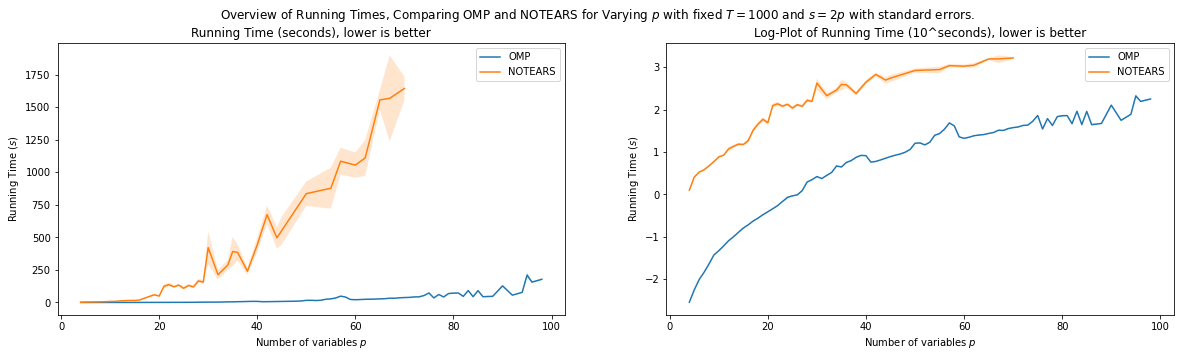

In [89]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle("Overview of Running Times, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['Running Time (seconds), lower is better', 'Log-Plot of Running Time (10^seconds), lower is better']

axs[0].plot(Ps_OMP, OMP_means[:, 0], label = "OMP")
axs[0].fill_between(Ps_OMP, OMP_means[:, 0] - OMP_ses[:, 0], OMP_means[:, 0] + OMP_ses[:, 0], alpha = 0.2)

axs[0].plot(Ps_NT, NT_means[:, 0], label = "NOTEARS")
axs[0].fill_between(Ps_NT, NT_means[:, 0] - NT_ses[:, 0], NT_means[:, 0] + NT_ses[:, 0], alpha = 0.2)
 
axs[1].plot(Ps_OMP, np.log10(OMP_means[:, 0]), label = "OMP")
axs[1].fill_between(Ps_OMP, np.log10(OMP_means[:, 0] - OMP_ses[:, 0]), np.log10(OMP_means[:, 0] + OMP_ses[:, 0]), alpha = 0.2)

axs[1].plot(Ps_NT, np.log10(NT_means[:, 0]), label = "NOTEARS")
axs[1].fill_between(Ps_NT, np.log10(NT_means[:, 0] - NT_ses[:, 0]), np.log10(NT_means[:, 0] + NT_ses[:, 0]), alpha = 0.2)

for i in range(2):
    axs[i].set_title(titles[i])
    axs[i].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='Running Time ($s$)')

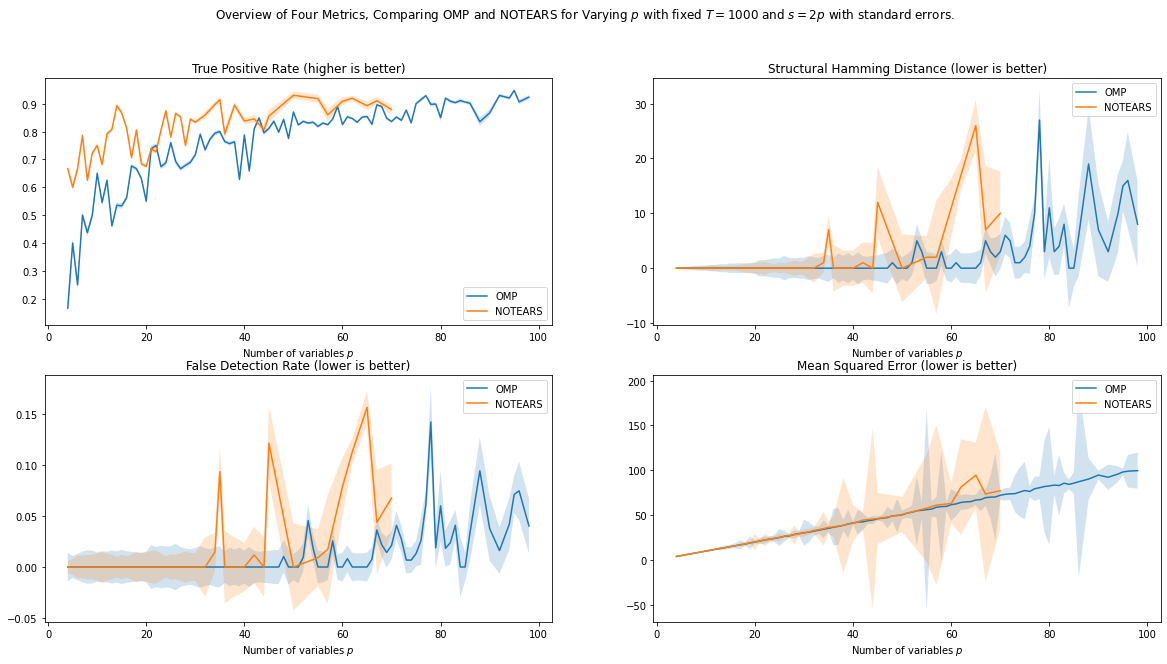

In [96]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(0, 4):
    axs[i % 2, i // 2].plot(Ps_OMP, OMP_means[:, i + 1], label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps_OMP, OMP_means[:, i + 1] - OMP_ses[:, i + 1], OMP_means[:, i + 1] + OMP_ses[:, i + 1], alpha = 0.2)

    axs[i % 2, i // 2].plot(Ps_NT, NT_means[:, i + 1], label = "NOTEARS")
    axs[i % 2, i // 2].fill_between(Ps_NT, NT_means[:, i + 1] - NT_ses[:, i + 1], NT_means[:, i + 1] + NT_ses[:, i + 1], alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(4):
    axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1), label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1) - scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), np.mean(np.array(r_OMP)[:, i + 1], axis = 1) + scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), alpha = 0.2)

#     axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1), label = "NOTEARS")
#     axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1) - scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), np.mean(np.array(r_NT)[:, i + 1], axis = 1) + scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')